In [1]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install fasttext

     |████████████████████████████████| 71kB 3.2MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3098224 sha256=64acbd40bd59bb6e5e2df15cc8730b977b913ef3b247aa3648584cc8b67c84ff
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [3]:
#Downloading libraries
!pip install -U sentence-transformers

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 2.1MB 8.3MB/s 
     |████████████████████████████████| 1.2MB 51.0MB/s 
     |████████████████████████████████| 3.3MB 54.2MB/s 
     |████████████████████████████████| 901kB 55.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=aba3e7bc42700fb2aff816c31aa15f2e568e109d119d9944ad26bc2636eaaea0
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [5]:
cv  = pd.read_csv('drive/My Drive/Thesis/Data/covid_data_2021.csv')
cv_case = cv[['Date','New Cases']]


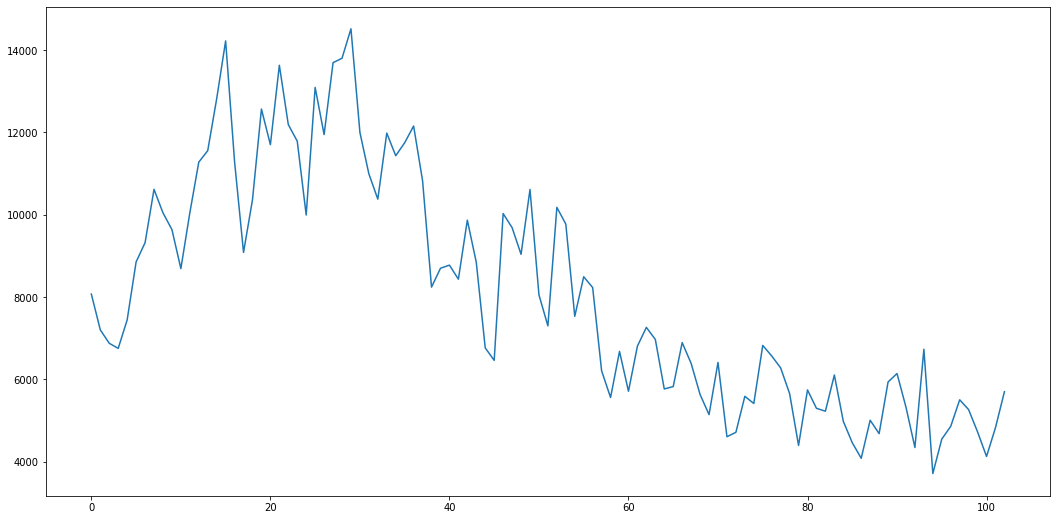

In [6]:
new_cases = cv_case[['New Cases']]
plt.subplots(figsize=(18, 9))
plt.plot(new_cases)
plt.show()

Prediction using covid new case

7 days 

In [7]:
covid_data = new_cases.values.astype(float)

train_data = covid_data[:31]
test_data = covid_data[31:38]

print(len(train_data))
print(len(test_data))

31
7


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 7

def create_inout_sequences(input_data, tw):
  inout_seq = []
  L = len(input_data)
  for i in range(L-tw):
    train_seq = input_data[i:i+tw]
    train_label = input_data[i+tw:i+tw+1]
    inout_seq.append((train_seq, train_label))
  return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [9]:
#Model
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size
    self.lstm = nn.LSTM(input_size, hidden_layer_size)
    self.linear = nn.Linear(hidden_layer_size, output_size)
    self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                        torch.zeros(1,1,self.hidden_layer_size))
    
  def forward(self, input_seq):
    lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
    predictions = self.linear(lstm_out.view(len(input_seq), -1))
    return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
#Training
epochs = 1000

for i in range(epochs):
  for seq, labels in train_inout_seq:
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                         torch.zeros(1, 1, model.hidden_layer_size))
    
    y_pred = model(seq)

    single_loss = loss_function(y_pred, labels)
    single_loss.backward()
    optimizer.step()

  if i%100==1:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.00843240
epoch: 101 loss: 0.02983737
epoch: 201 loss: 0.00003965
epoch: 301 loss: 0.00013103
epoch: 401 loss: 0.00071942
epoch: 501 loss: 0.00006022
epoch: 601 loss: 0.00001363
epoch: 701 loss: 0.00130177
epoch: 801 loss: 0.00057935
epoch: 901 loss: 0.00552934
epoch: 999 loss: 0.0000000000


In [11]:
#Prediction
fut_pred = 7

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

model.eval()

for i in range(fut_pred):
  seq = torch.FloatTensor(test_inputs[-train_window:])
  with torch.no_grad():
    model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                    torch.zeros(1, 1, model.hidden_layer_size))
    test_inputs.append(model(seq).item())

test_inputs[fut_pred:]
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)



[-0.16522859036922455, 0.6332260370254517, 0.3380553722381592, 0.7880231738090515, 0.8155827522277832, 1.0, 0.3517063856124878]
[[10253.42926736]
 [ 9378.91324486]
 [11473.66390272]
 [12106.16718258]
 [13347.16396976]
 [13077.60155666]
 [13832.9189353 ]]


In [14]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mse(predict,target):
    return ((predict-target)**2).mean()

def mae(predict,target):
    return (abs(predict-target)).mean()

def mape(predict,target):
    return ( abs((target - predict) / target).mean()) * 100

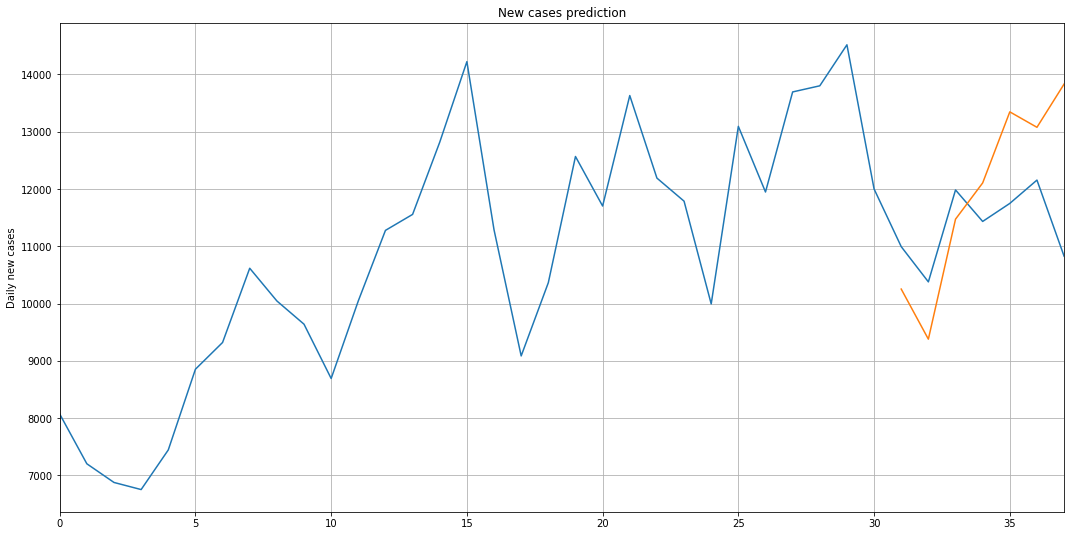

In [16]:
#plotting prediction
model = 'lstm'
dr = 'drive/My Drive/Thesis/Data/images/prediction1/'
x = np.arange(31, 38, 1)
plt.subplots(figsize=(18, 9))
plt.title('New cases prediction')
plt.ylabel('Daily new cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(covid_data[:38])
plt.plot(x,actual_predictions)
plt.savefig(dr + model + '_prediction')   
plt.show()

In [15]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions))
print('MAPE : ', mape (cov[-7:], actual_predictions))
print('MSE : ', mse( cov[-7:], actual_predictions))
print('RMSE : ', rmse( cov[-7:], actual_predictions))

MAE :  New Cases    1206.97789
dtype: float64
MAPE :  New Cases    9.805305
dtype: float64
MSE :  New Cases    2.099985e+06
dtype: float64
RMSE :  New Cases    1449.132565
dtype: float64


Prediction using covid new cases and tweets

7 days

In [ ]:
#Importing dependencies
import gensim
from gensim.models import KeyedVectors
from gensim import corpora
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
import os
from sentence_transformers import SentenceTransformer
import copy
from datetime import datetime
import warnings
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import contextlib
import spacy
import re
import random
import math
from gensim.utils import simple_preprocess
import fasttext.util


#word2vec, glove, fasttext
class WordVecVectorizer(object):
    def __init__(self, model, method):
        self.model = model
        self.method = method

        if method == 'WORD2VEC':
          self.dim = 100 
                     
        elif method == 'GLOVE':
           self.dim = 5 
           
        elif method == 'FASTTEXT':           
            self.dim = 300
        else:
          self.dim = 200
       
        
    def fit(self, X, y):
        return self    
        
    def transform(self, X):
        return np.array([
            np.mean([self.model[w] for w in texts.split() if w in self.model]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X              
        ])

In [ ]:
def plotting(pred, mod, ds):
  dr = 'drive/My Drive/Thesis/Data/images/prediction1/'
  x = np.arange(31, 38, 1)
  plt.subplots(figsize=(18, 9))
  plt.title('New cases prediction')
  plt.ylabel('Daily new cases')
  plt.grid(True)
  plt.autoscale(axis='x', tight=True)
  plt.plot(new_cases[:38])
  plt.plot(x,pred)
  plt.savefig(dr + mod + '_prediction_' + ds)   
  plt.show()


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mse(predict,target):
    return ((predict-target)**2).mean()

def mae(predict,target):
    return (abs(predict-target)).mean()

def mape(predict,target):
    return ( abs((target - predict) / target).mean()) * 100




In [ ]:
def create_inout_sequences(input_data, tw):
  inout_seq = []
  L = len(input_data)
  for i in range(L-tw):
    train_seq = input_data[i:i+tw]
    train_label = input_data[i+tw:i+tw+1]
    inout_seq.append((train_seq, train_label))
  return inout_seq


In [ ]:
#Model
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size
    self.lstm = nn.LSTM(input_size, hidden_layer_size)
    self.linear = nn.Linear(hidden_layer_size, output_size)
    self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                        torch.zeros(1,1,self.hidden_layer_size))
    
  def forward(self, input_seq):
    lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
    predictions = self.linear(lstm_out.view(len(input_seq), -1))
    return predictions[-1]

In [ ]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel



def vectorize(method, sentences):
  if method == 'BOW':
    print('Getting vector representations for BoW ...')
    dictionary = corpora.Dictionary()
    doc_tokenized = [simple_preprocess(doc) for doc in sentences]
    BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]
    vec = np.array(BoW_corpus)
    print('Getting vector representations for BoW. Done!')
    return vec

  elif method == 'BERT':
    print('Getting vector representations for BERT ...')
    model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
    vec = np.array(model.encode(sentences, show_progress_bar=True))
    print('Getting vector representations for BERT. Done!')
    return vec

  elif method == 'WORD2VEC':
     print('Getting vector representations for WORD2VEC ...')
     model = gensim.models.KeyedVectors.load_word2vec_format('drive/My Drive/Thesis/pretrained_model/word2vec/model.bin', binary=True) 
     wtv_vect = WordVecVectorizer(model, method)
     embeddings = wtv_vect.transform(sentences)
     vec = np.vstack(embeddings)
     print('Getting vector representations for WORD2VEC. Done!')
     return vec

  elif method == 'GLOVE':
    print('Getting vector representations for GLOVE ...')
    model = loadGloveModel("drive/My Drive/Thesis/Data/gensim_glove_vectors.txt") 
    wtv_vect = WordVecVectorizer(model, method)
    embeddings = wtv_vect.transform(sentences)
    vec = np.vstack(embeddings)
    print('Getting vector representations for GLOVE. Done!')
    return vec

  elif method == 'FASTTEXT':
    print('Getting vector representations for FASTTEXT ...')
    #loading the model
    model = fasttext.load_model('drive/My Drive/Thesis/pretrained_model/fasttext/model.bin') 
    wtv_vect = WordVecVectorizer(model, method)
    embeddings = wtv_vect.transform(sentences)
    vec = np.vstack(embeddings)
    print('Getting vector representations for FASTTEXT. Done!')
    return vec       
        
        
  
            

       

In [ ]:
#loading covid data 
cv  = pd.read_csv('drive/My Drive/Thesis/Data/covid_data_2021.csv')
new_cases = cv['New Cases']
cv_feature = new_cases[:31]




In [ ]:
#loading tweet data
tw  = pd.read_csv('drive/My Drive/Thesis/Data/Tweet_TM/test1/fasttext_cluster_3_combined.csv')
tw_feature = tw['clean_sentences']
tw_feature


0     al ahwa ely baod leha kol youm maby odsh er an...
1     bc itne buray covid halaat mai bi shadian chal...
2     indonesia china korea i love it,covid lang ang...
3     zdlkdnxlsm it s time to review for cets na bwi...
4     ah infeksi suspek covid melulu db tipesnyaa ma...
5     corona do iya thang,selamatpagijogja l kompas ...
6     indonesia covid fk cd usa fk cd,past is past c...
7     the queue of people wanting to do covid test a...
8     ab ye afwah kon phela raha hai terang band kr ...
9     covid part ii psbb again,indonesia china korea...
10    go bunga missuniverse indonesia,vai toma nomor...
11    indonesia gemar mu do umuk,tebakangaring nama ...
12    da matsalar asuu da matsalar corona wacce wani...
13    so na kakak wiliki tu qo noqu tl kemuni yaga c...
14    kerja pending boss xbagi kje bahaya covid my b...
15    t t a mesti jam nya indonesia tidur lorot,covi...
16    ebarg ung patay sa lindol sa indonesia uy ayos...
17    allahumma a uzubika wa ahli min ruuhi wa r

In [ ]:
#create vector for tweets
method = 'FASTTEXT'
tweet_feature  = vectorize(method, tw_feature)



Getting vector representations for FASTTEXT ...


Getting vector representations for FASTTEXT. Done!


In [ ]:
tweet_feature.shape

(31, 300)

In [ ]:
#Bow
from torch.nn.utils.rnn import pad_sequence
t = pad_sequence([torch.tensor(x) for x in tweet_feature], batch_first=True)

t.shape

torch.Size([31, 1475, 2])

In [ ]:
#concatenating features Bow
x1 = torch.Tensor(cv_feature)
x2 = pad_sequence([torch.tensor(x) for x in tweet_feature], batch_first=True)
x2 = x2.view(31,2950)
x1 = x1.view(31, 1) 
x = torch.cat((x1, x2),1)

x = x.detach().numpy()
train_data = np.array([])
for x in x:
  train_data = np.append(train_data, x[0])
train_data.shape

(31,)

In [ ]:
#concatenating features

features = nn.Sequential(
            nn.Linear(300, 1),
            nn.ReLU(),
        )

x1 = torch.Tensor(cv_feature)
x2 = features(torch.Tensor(tweet_feature))
x1 = x1.view(31, 1) 
x = torch.cat((x1, x2),1)

x = x.detach().numpy()
train_data = np.array([])
for x in x:
  train_data = np.append(train_data, x[0])
train_data.shape

(31,)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 7

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

#MODEL
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Training
epochs = 1000

for i in range(epochs):
  for seq, labels in train_inout_seq:
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                         torch.zeros(1, 1, model.hidden_layer_size))
    
    y_pred = model(seq)

    single_loss = loss_function(y_pred, labels)
    single_loss.backward()
    optimizer.step()

  if i%100==1:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00274761
epoch: 101 loss: 0.00011733
epoch: 201 loss: 0.00000006
epoch: 301 loss: 0.00041197
epoch: 401 loss: 0.00010376
epoch: 501 loss: 0.00096873
epoch: 601 loss: 0.00534365
epoch: 701 loss: 0.00000540
epoch: 801 loss: 0.00019762
epoch: 901 loss: 0.00004735
epoch: 999 loss: 0.0005779036


In [ ]:
#Prediction
test_data = new_cases[31:38]
fut_pred = 7

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

model.eval()

for i in range(fut_pred):
  seq = torch.FloatTensor(test_inputs[-train_window:])
  with torch.no_grad():
    model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                    torch.zeros(1, 1, model.hidden_layer_size))
    test_inputs.append(model(seq).item())

test_inputs[fut_pred:]
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)


[-0.16522859036922455, 0.6332260370254517, 0.3380553722381592, 0.7880231738090515, 0.8155827522277832, 1.0, 0.3517063856124878]
[[11076.23930331]
 [ 9768.4929325 ]
 [11542.78774674]
 [11790.24967703]
 [11881.5446433 ]
 [12854.44364312]
 [13110.21418306]]


Bow Topic 0

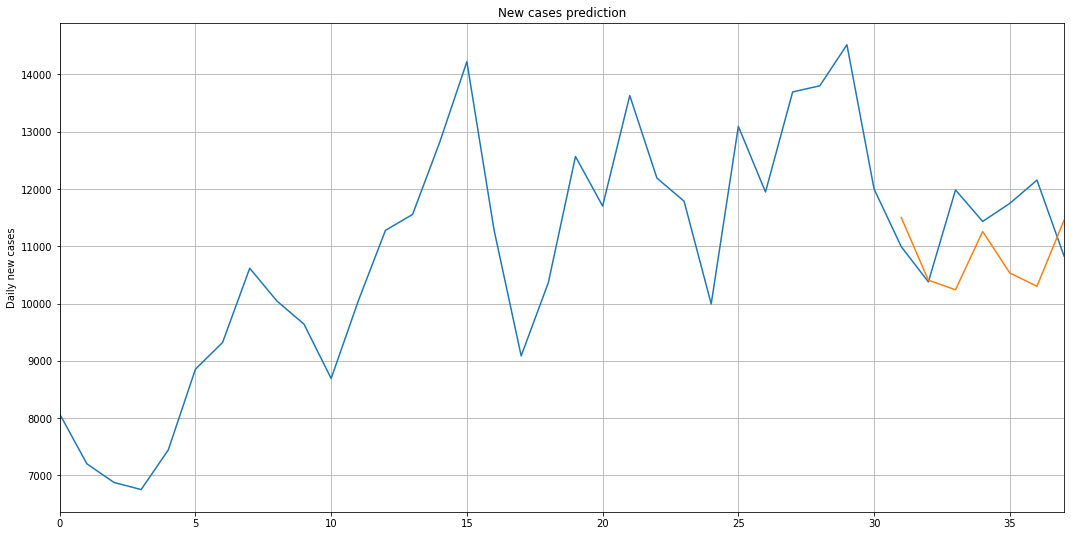

In [ ]:
#plotting prediction
model = 'BOW'
dataset = '0'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  879.2825759627989
MAPE :  8.329552903555737
MSE :  1234022.1842432062
RMSE :  1110.8655113213329


Bow Topic 1

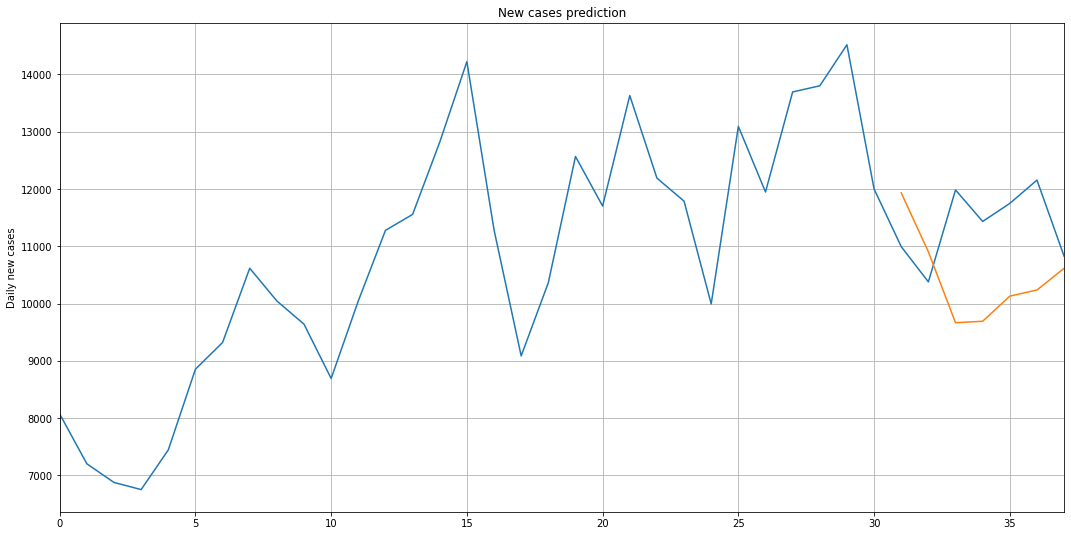

In [ ]:
#plotting prediction
model = 'BOW'
dataset = '1'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  1324.8669443375297
MAPE :  13.05222224481645
MSE :  2273525.4252537135
RMSE :  1507.821416897145


Bow Topic 2

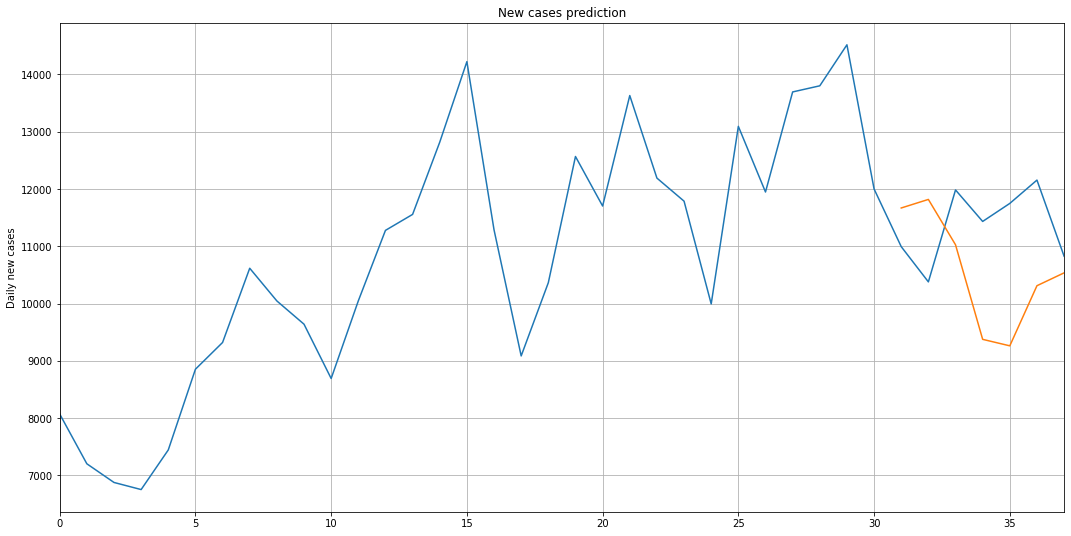

In [ ]:
#plotting prediction
model = 'BOW'
dataset = '2'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  1393.083575308323
MAPE :  13.727210246388012
MSE :  2478629.077671945
RMSE :  1574.36624635818


Bow Topic 3

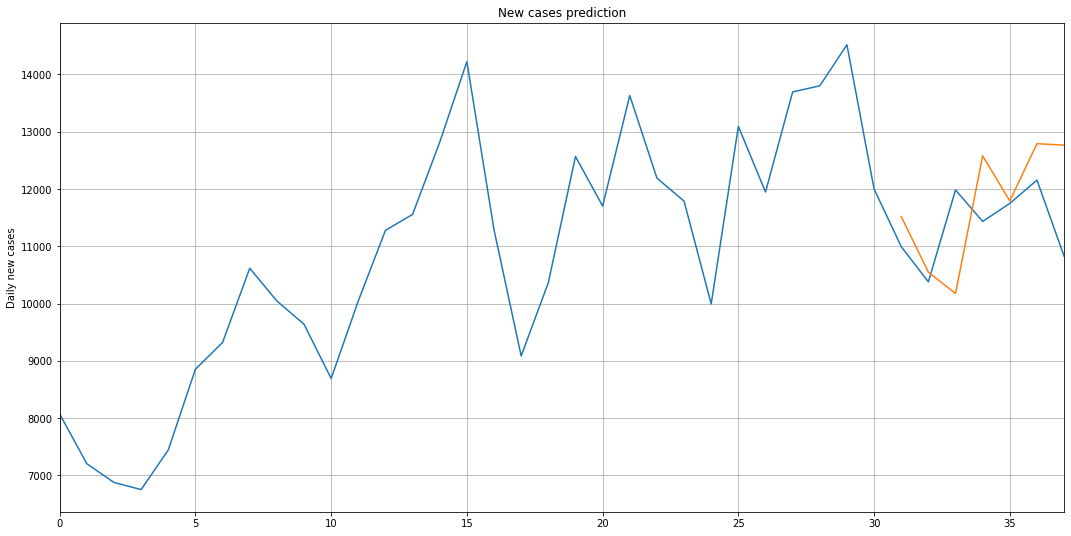

In [ ]:
#plotting prediction
model = 'BOW'
dataset = '3'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  895.6445575079748
MAPE :  7.656293099621221
MSE :  1294261.8362441375
RMSE :  1137.6562909086986


Word2vec Topic 0

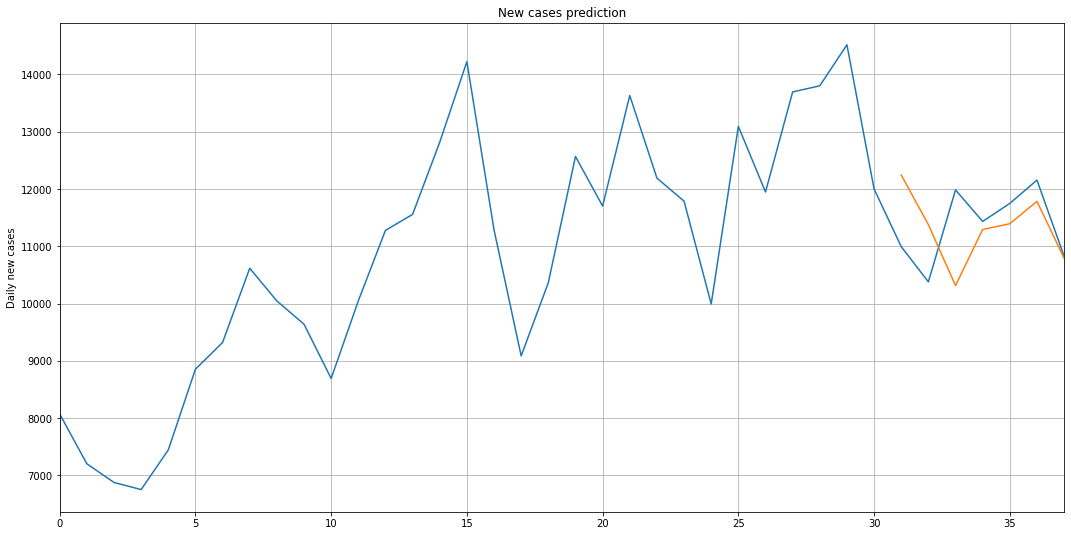

In [ ]:
#plotting prediction
model = 'word2vec'
dataset = '0'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  688.739775309073
MAPE :  6.145398453934288
MSE :  805376.3491647684
RMSE :  897.4276289288002


Word2vec Topic 1

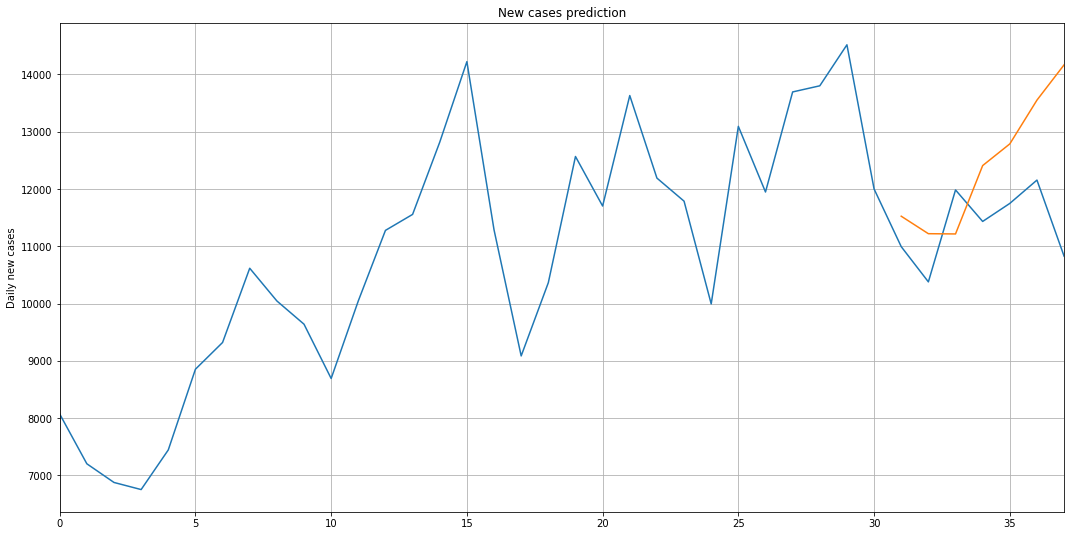

In [ ]:
#plotting prediction
model = 'word2vec'
dataset = '1'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  1270.3227864950895
MAPE :  9.832022704902828
MSE :  2389150.934663649
RMSE :  1545.687851625822


Word2vec Topic 2

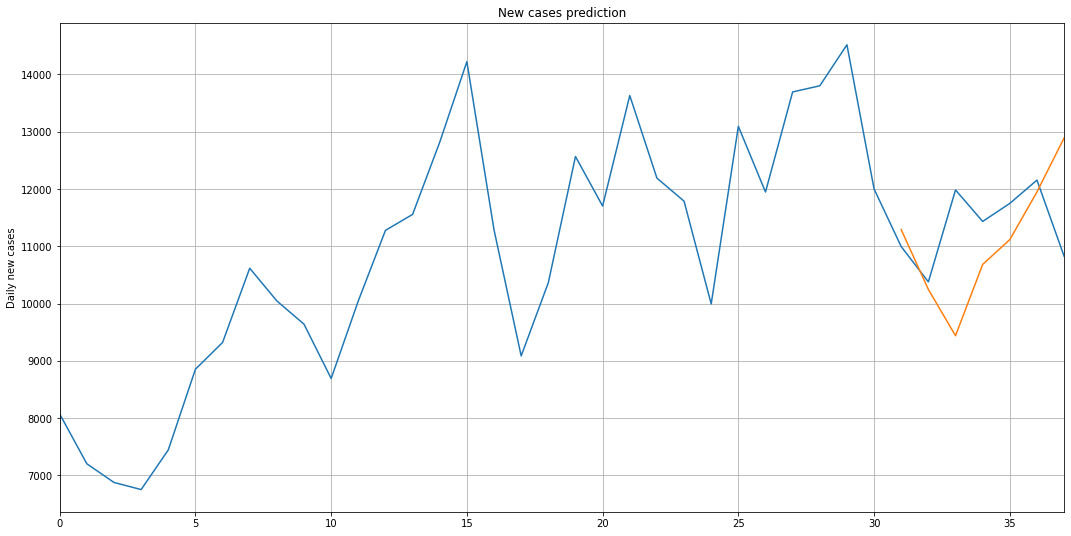

In [ ]:
#plotting prediction
model = 'word2vec'
dataset = '2'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  946.9014587742942
MAPE :  8.763099326654766
MSE :  1693168.5385596864
RMSE :  1301.2180979988275


Word2vec Topic 3

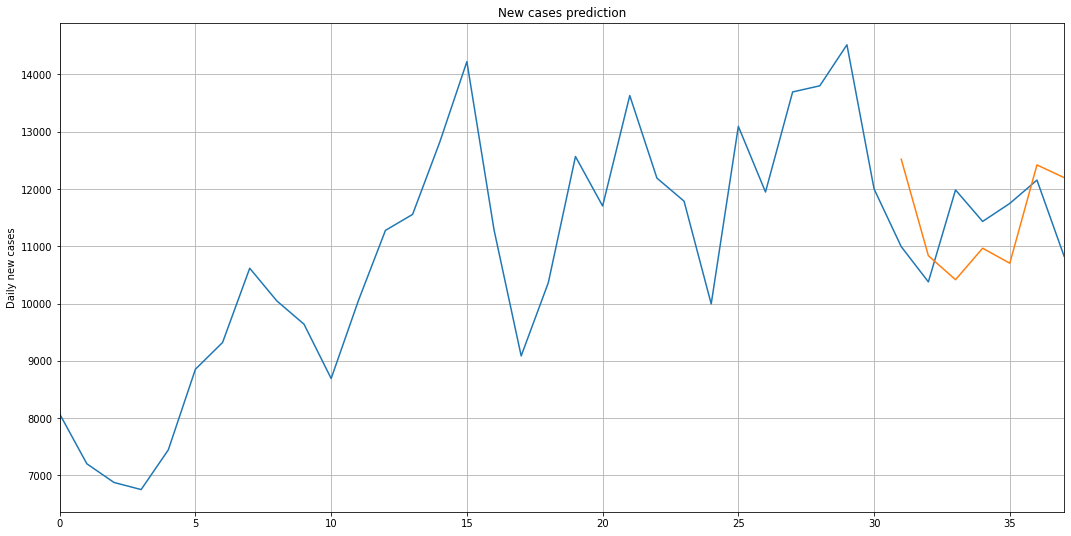

In [ ]:
#plotting prediction
model = 'word2vec'
dataset = '3'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  957.096296758524
MAPE :  8.407700209245025
MSE :  1179697.4375741095
RMSE :  1086.1387745468392


Glove Topic 0

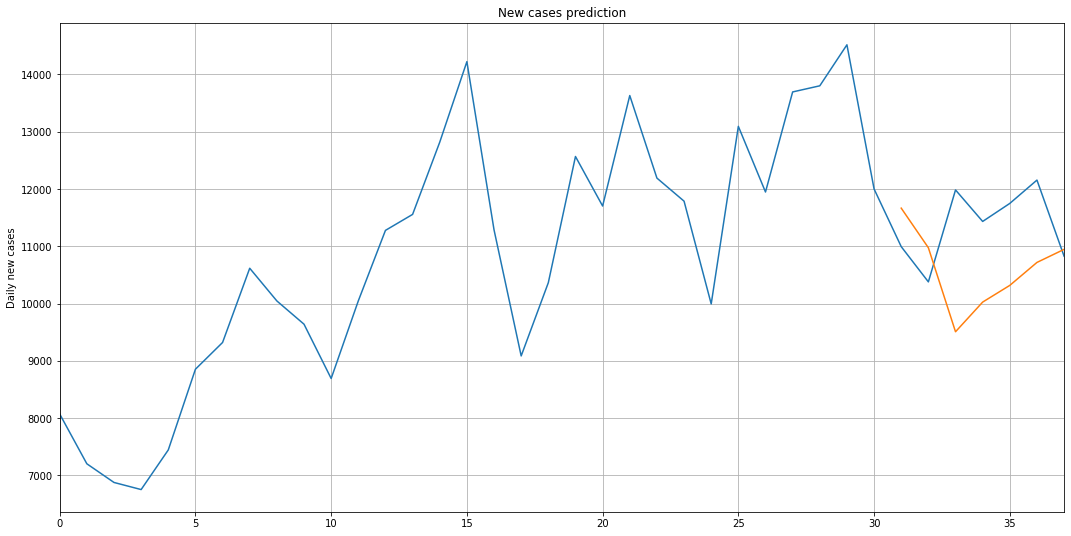

In [ ]:
#plotting prediction
model = 'glove'
dataset = '0'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  1162.9147834064704
MAPE :  11.378729565138858
MSE :  1864107.5634799206
RMSE :  1365.3232450522187


Glove Topic 1

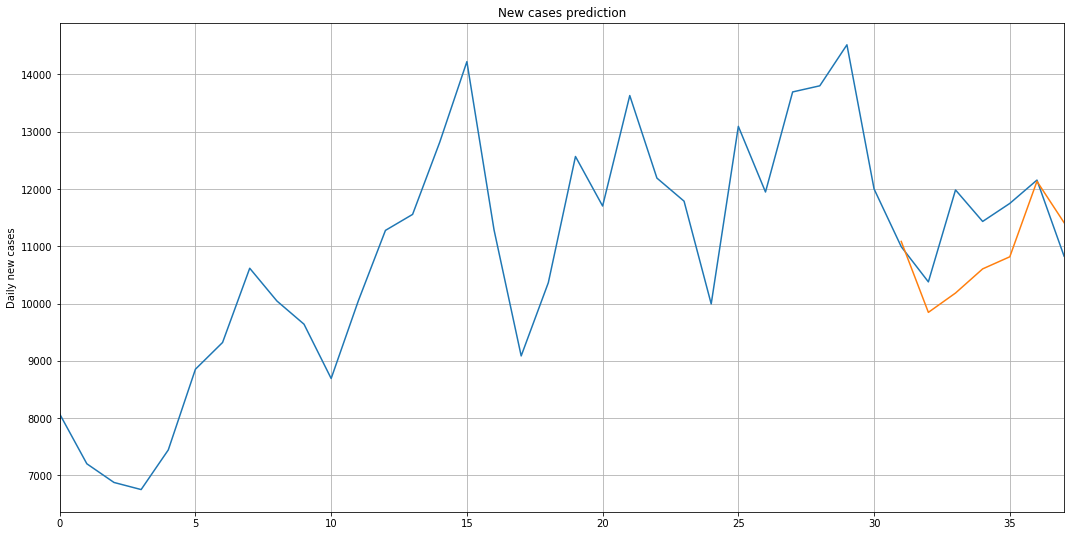

In [ ]:
#plotting prediction
model = 'glove'
dataset = '1'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  684.2721326340522
MAPE :  6.518364722020909
MSE :  775460.924429806
RMSE :  880.6025916551722


Glove Topic 2

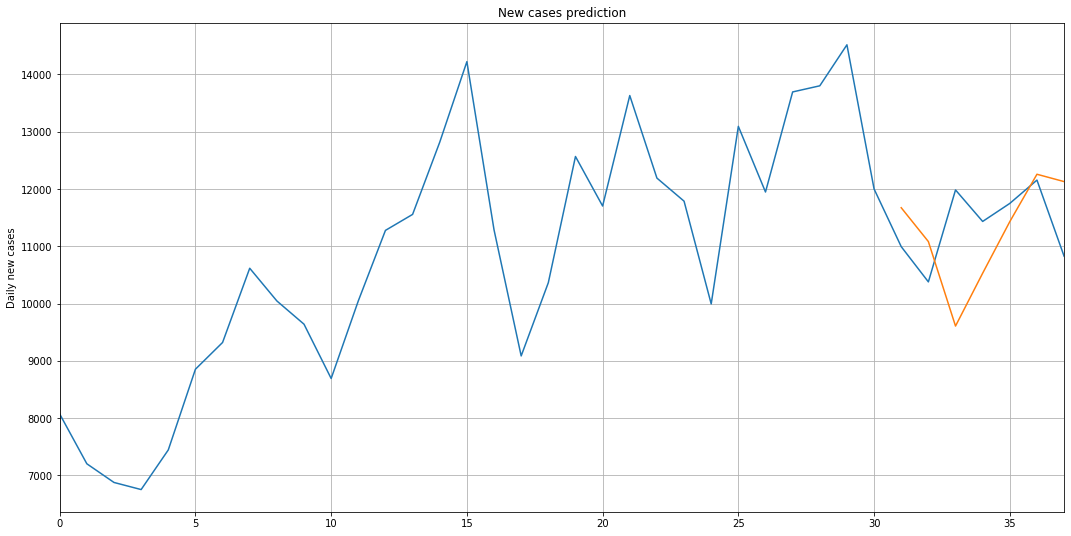

In [ ]:
#plotting prediction
model = 'glove'
dataset = '2'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  912.2537742895739
MAPE :  8.548408516397608
MSE :  1318494.1974853997
RMSE :  1148.2570258811395


Glove Topic 3

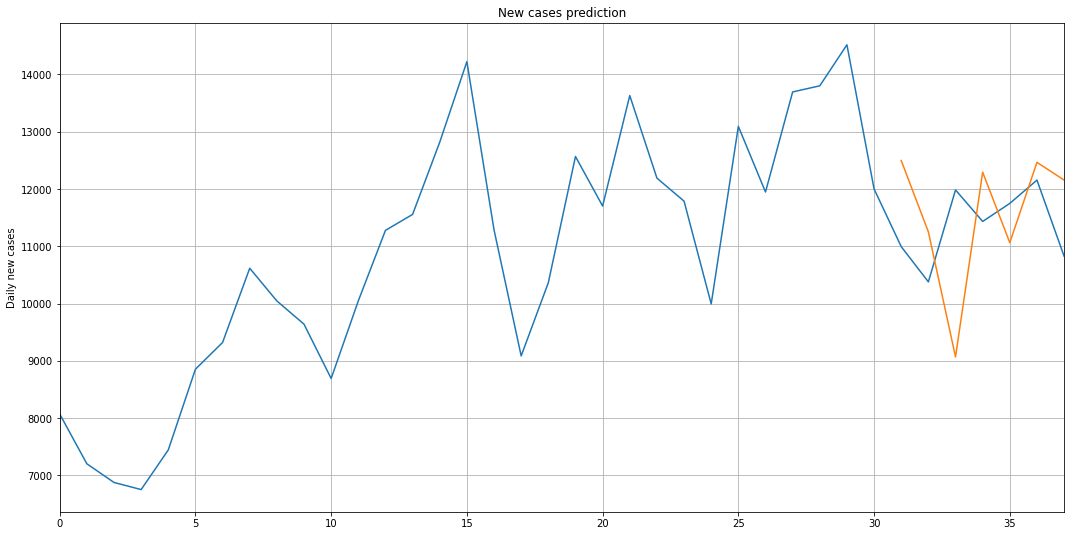

In [ ]:
#plotting prediction
model = 'glove'
dataset = '3'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  1210.742678792349
MAPE :  11.218898618251039
MSE :  2084188.8159908184
RMSE :  1443.6719904434035


FastText Topic 0

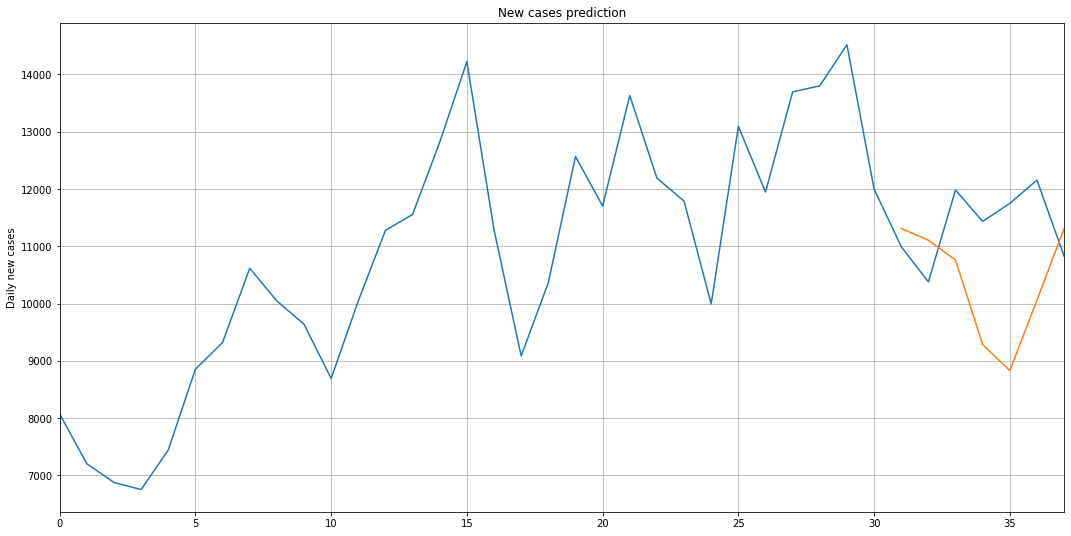

In [ ]:
#plotting prediction
model = 'fasttext'
dataset = '0'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  1416.6147951888186
MAPE :  14.577926755610468
MSE :  2842324.601255972
RMSE :  1685.9195120930215


FastText Topic 1

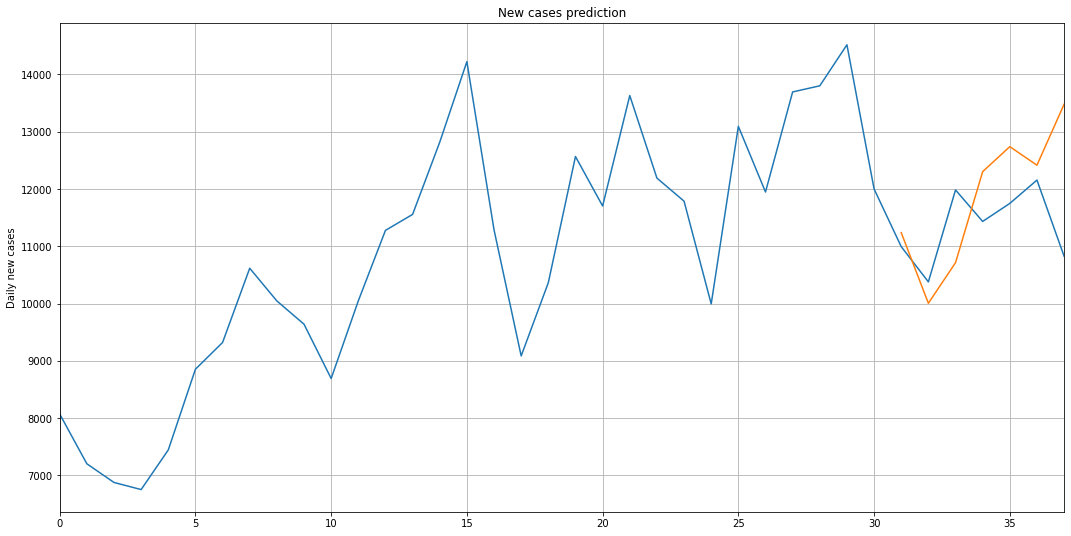

In [ ]:
#plotting prediction
model = 'fasttext'
dataset = '1'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  951.5919074054275
MAPE :  7.768815725897234
MSE :  1522116.9625990056
RMSE :  1233.7410435739769


FastText Topic 2


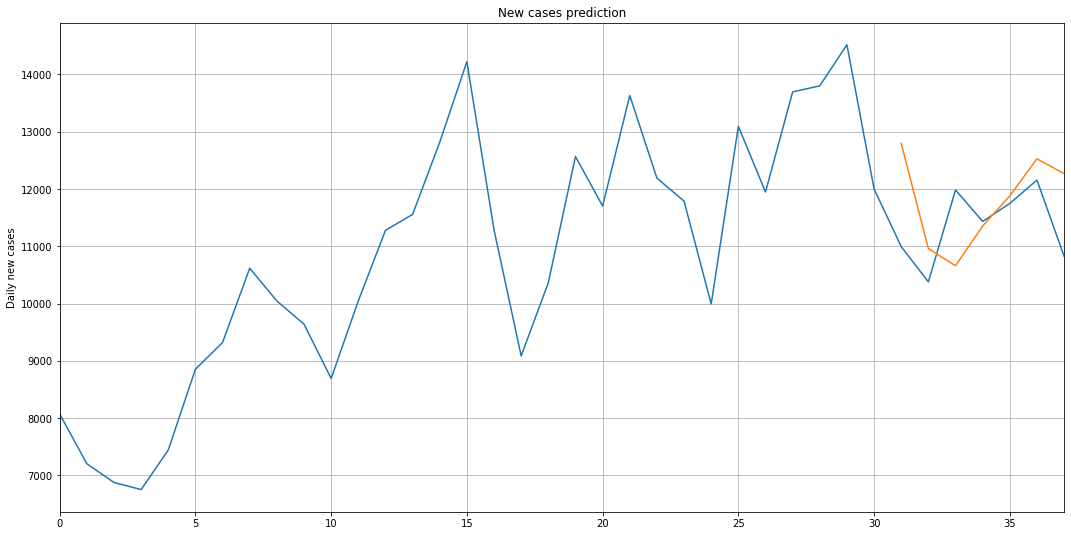

In [ ]:
#plotting prediction
model = 'fasttext'
dataset = '2'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  818.847093607166
MAPE :  6.904711406833659
MSE :  1082501.674886932
RMSE :  1040.4334072332222


FastText Topic 3


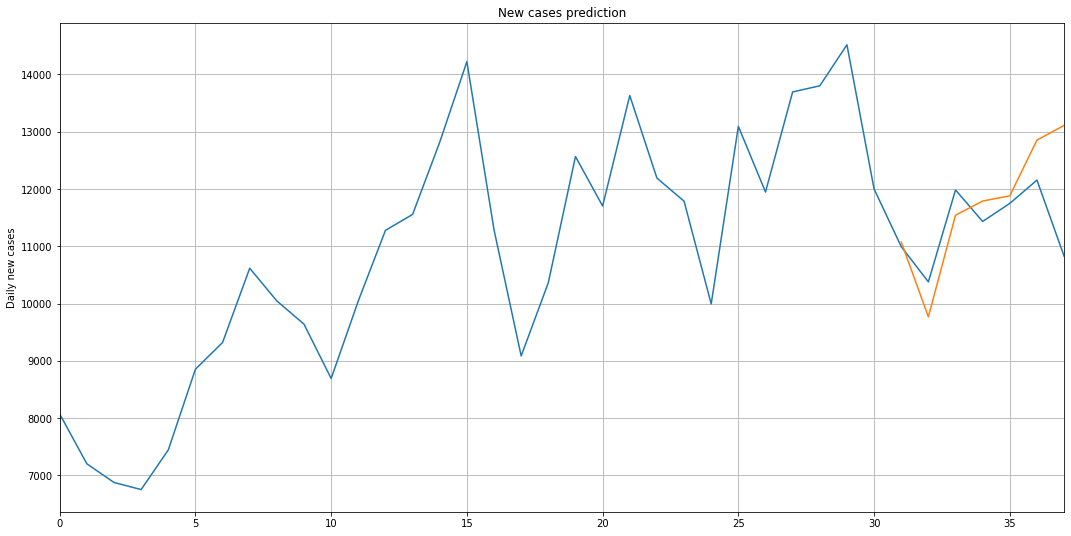

In [ ]:
#plotting prediction
model = 'fasttext'
dataset = '3'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  657.772967225739
MAPE :  5.400110956638488
MSE :  917074.6968729222
RMSE :  957.6401708746988


Bert Topic 0

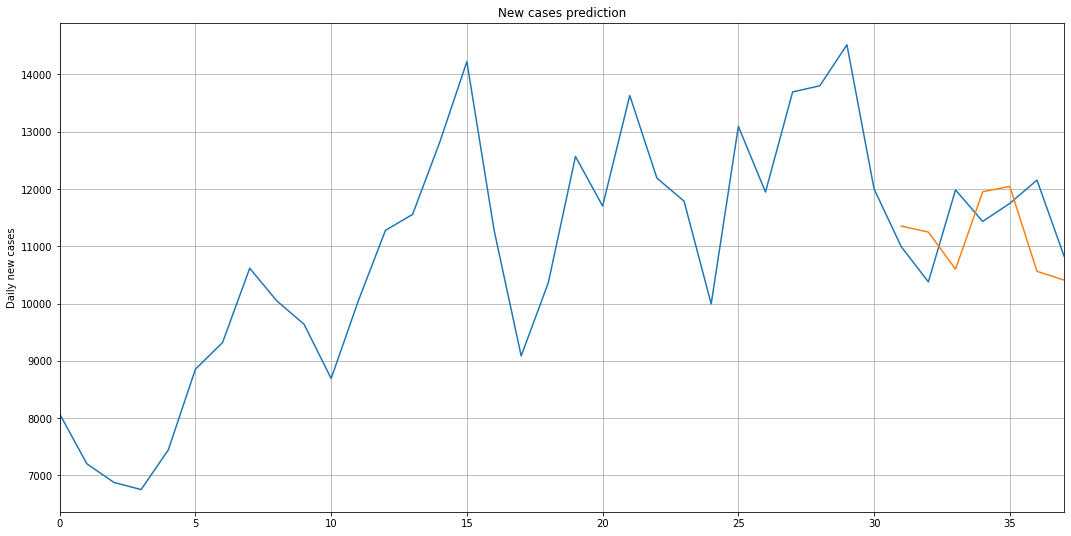

In [ ]:
#plotting prediction
model = 'bert'
dataset = '0'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  776.4807419127652
MAPE :  7.116310807062448
MSE :  837715.2120352328
RMSE :  915.2678362289548


Bert Topic 1

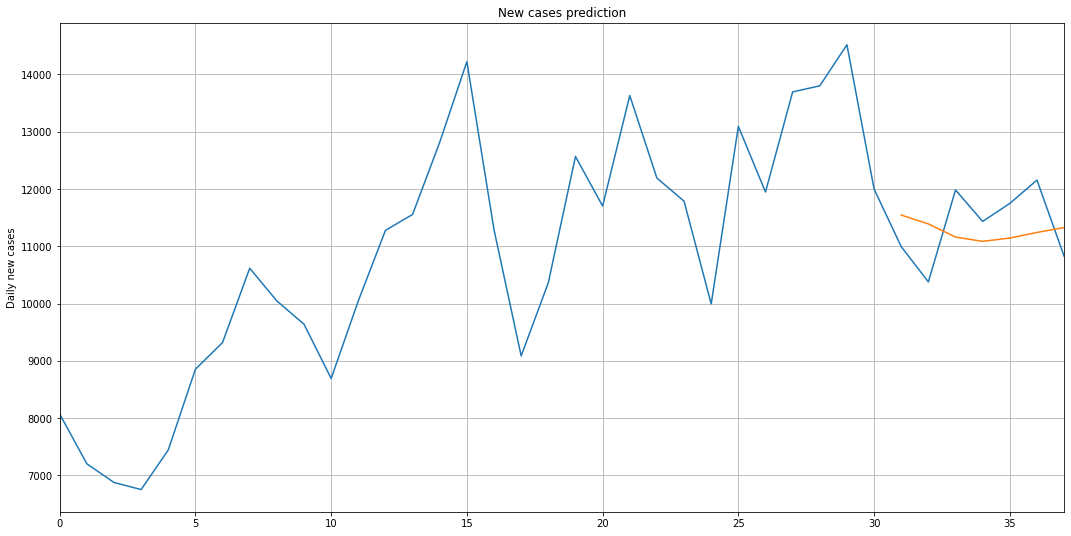

In [ ]:
#plotting prediction
model = 'bert'
dataset = '1'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  678.9171753610883
MAPE :  6.019627540086118
MSE :  510985.0349725767
RMSE :  714.8321725919845


Bert Topic 2

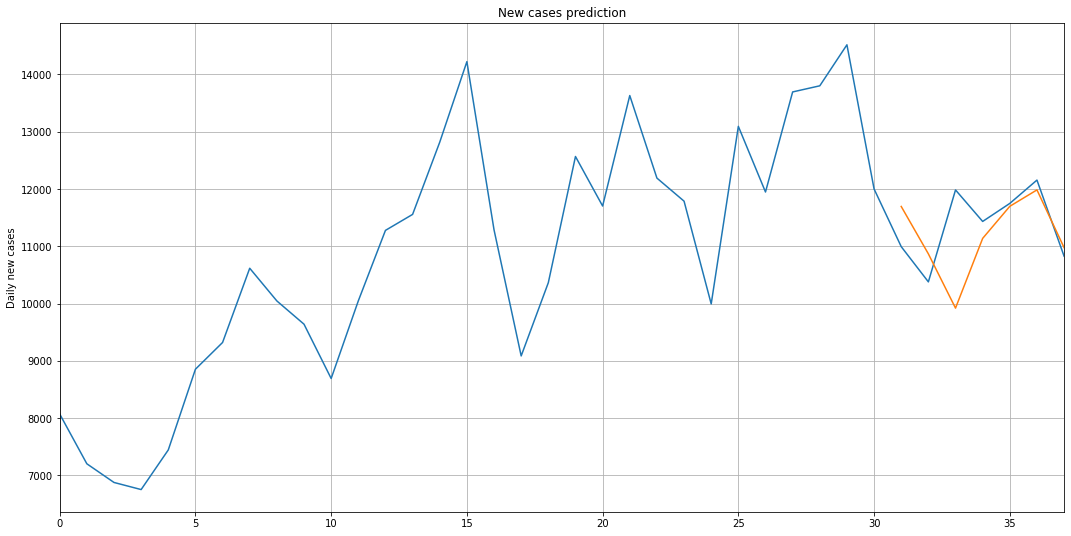

In [ ]:
#plotting prediction
model = 'bert'
dataset = '2'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  560.100940708071
MAPE :  5.310310424072913
MSE :  732889.1533983535
RMSE :  856.0894540866354


Bert Topic 3

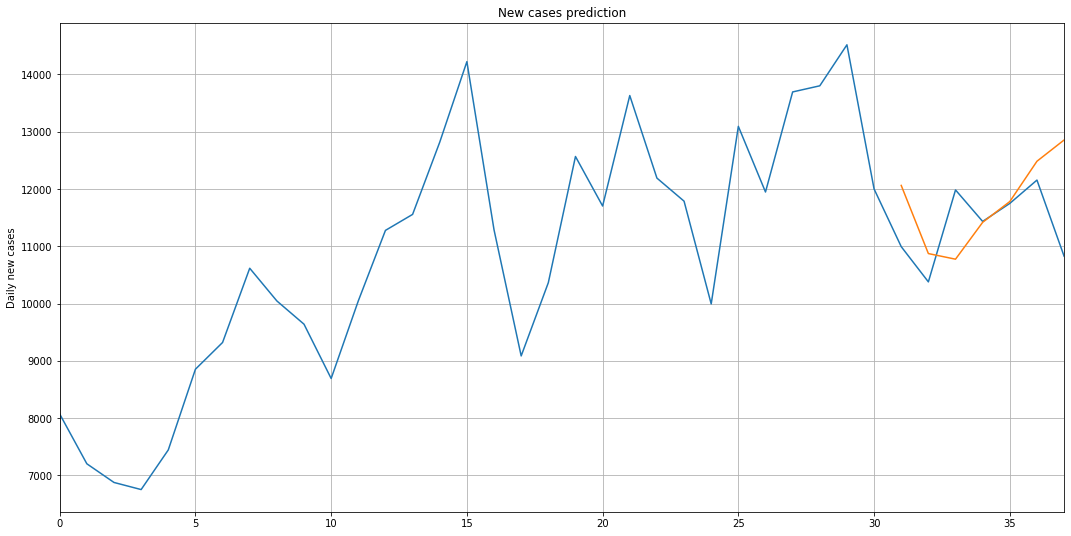

In [ ]:
#plotting prediction
model = 'bert'
dataset = '3'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  739.6140284900155
MAPE :  6.206917158211183
MSE :  1010624.6224431648
RMSE :  1005.2982753606836
